In [1]:
### GROUP 2 ###

# B.J.T. Donkers - 1506897
# S. van der Leek - 1564226
# L. Sloot - 1365711
# S. Diemel  - 1645749
# A.E. Murariu - 1532081
# Z.V. Petrov - 1554999

In [2]:
# imports
import pandas as pd
import pm4py

In [3]:
# read the data (2012)
df_total = pm4py.convert_to_dataframe(pm4py.read_xes("data/BPI_Challenge_2012.xes"))

# read the data (road traffic fines)
# df = pd.read_csv('data/Road_Traffic_Fine_Management_Process-training.csv')

# read the data (2017)
# df = pd.read_csv('data/BPI Challenge 2017-training.csv')

# read the data (2018)
# df = pd.read_csv('data/BPI Challenge 2018-training.csv')

df_total.head(10)

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
5,10862,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
6,10862,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
7,10862,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
8,10862,COMPLETE,O_CREATED,2011-10-01 11:45:11.197000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
9,10862,COMPLETE,O_SENT,2011-10-01 11:45:11.380000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000


In [4]:
# Percentage cut-off points for training, validation and testing datasets
training_percentage = 0.70 
validation_percentage = 0.80

# Defining database-specific variables
case_column = "case:concept:name"
registration_time_column = "case:REG_DATE"
event_column = "concept:name"
timestamp_column = "time:timestamp"
amount_column = 'case:AMOUNT_REQ'
row_nr_column = 'row_nr'
index_column = "index"
# timeformat_registration = "%Y-%m-%dT%H:%M:%S" # new time format
# timeformat_timestamp = "%d-%m-%Y %H:%M:%S.%f"
lifecycle_column = 'lifecycle:transition' # additional info for the timePrediction_onTheFly, set to None if you don't want to use it
amount_column_in_data = True

# Names of new columns we will add in the notebooks
position_column = "Position" # added in this tool notebook
baseline_la_next_event_column = "Baseline Last Event Prediction for Next Activity" # added in the baseline notebook
baseline_la_next_timestamp_column = "Baseline Last Event Prediction for Next Timestamp" # added in the baseline notebook
baseline_pos_next_event_column = "Baseline Last Pos Prediction for Next Activity" # added in the baseline notebook
baseline_pos_next_timestamp_column = "Baseline Last Pos Prediction for Next Timestamp" # added in the baseline notebook
pred_event_otf = "OTF Prediction for Next Activity" # added by event_onthefly notebook
otf_next_timestamp_column = "OnTheFly Prediction for Next Timestamp" # added by the timePrediction_onTheFly notebook

In [5]:
# Basic data preprocessing of the timestamps and reg dates
df_total[timestamp_column] = [pd.Timestamp(time) for time in df_total[timestamp_column]]
df_total[registration_time_column]= [pd.Timestamp(reg_time) for reg_time in df_total[registration_time_column]]
df_total = df_total.sort_values(by=[case_column, timestamp_column]) # sort values by user and time of event

#df_total.head(10)

In [6]:
# We fill in the Position column that shows which position is a certain event in the trace (the first event is 1)
df_total[position_column] = df_total.groupby([case_column]).cumcount()+1

#df_total.head(10)

In [7]:
df_total = df_total.sort_values(by=[timestamp_column])

training_cutoff_timestamp = df_total.iloc[[int(training_percentage*len(df_total))]].iloc[0][timestamp_column]
validation_cutoff_timestamp = df_total.iloc[[int(validation_percentage*len(df_total))]].iloc[0][timestamp_column]

(training_cutoff_timestamp, validation_cutoff_timestamp)

(Timestamp('2012-01-26 11:14:40.465000+0100', tz='UTC+01:00'),
 Timestamp('2012-02-09 15:41:26.559000+0100', tz='UTC+01:00'))

In [8]:
# dictionary to store whether each case has an event that occured before and or after the cutoff timestamps

dict_overlapping_cases = {}

def find_overlapping_cases(case, timestamp):
    templist = [timestamp < training_cutoff_timestamp, timestamp > training_cutoff_timestamp, timestamp < validation_cutoff_timestamp, timestamp > validation_cutoff_timestamp]
    if (case in dict_overlapping_cases):
        dict_overlapping_cases[case] = [(a or b) for a,b in zip(templist, dict_overlapping_cases[case])]
    else:
        dict_overlapping_cases[case] = templist

[find_overlapping_cases(case,time) for case,time in zip(df_total[case_column],df_total[timestamp_column])]

def case_overlaps_a_timestamp(case):
    return (dict_overlapping_cases[case][0] and dict_overlapping_cases[case][1]) or (dict_overlapping_cases[case][2] and dict_overlapping_cases[case][3])

list_overlapping_cases = [case for case in dict_overlapping_cases.keys() if case_overlaps_a_timestamp(case)]
len(list_overlapping_cases)

1378

In [9]:
# splitting the data and removing all events belonging to cases that overlap the cutoff timestamps

df = df_total.iloc[:int(training_percentage*len(df_total))]
df_validation = df_total.iloc[int(training_percentage*len(df_total)):int(validation_percentage*len(df_total))]
df_test = df_total.iloc[int(validation_percentage*len(df_total)):]

df = df[[(case not in list_overlapping_cases) for case in df[case_column]]]
df_validation = df_validation[[(case not in list_overlapping_cases) for case in df_validation[case_column]]]
df_test = df_test[[(case not in list_overlapping_cases) for case in df_test[case_column]]]

# without removing overlapping events: (262200, 183540, 26220, 52440)
# with removing overlapping events: (262200, 161548, 5198, 37781)
(len(df_total),len(df),len(df_validation),len(df_test)) 

(262200, 161548, 5198, 37781)

In [10]:
### this cell is not allowed here

df = df.sort_values(by=[case_column, timestamp_column])
df_validation = df_validation.sort_values(by=[case_column, timestamp_column])
df_test = df_test.sort_values(by=[case_column, timestamp_column])

In [25]:
# Running the notebook that adds the baseline predictions to df and df_test
%run -i "Baseline Prediction Tool.ipynb"

TypeError: Timestamp subtraction must have the same timezones or no timezones

TypeError: Timestamp subtraction must have the same timezones or no timezones

In [ ]:
# Accuracy % of the baseline based on last event, event predictions:

training_event_accuracy = len(df[(df[baseline_la_next_event_column].shift(periods=1)==df[event_column]) & (df[case_column].shift(periods=1) == df[case_column])]) * 100 / len(df[df[case_column].shift(periods=1) == df[case_column]])

test_event_accuracy = len(df_test[(df_test[baseline_la_next_event_column].shift(periods=1)==df_test[event_column]) & (df_test[case_column].shift(periods=1) == df_test[case_column])]) * 100 / len(df_test[df_test[case_column].shift(periods=1) == df_test[case_column]])

training_event_accuracy, test_event_accuracy

In [ ]:
# Accuracy % of the baseline based on last position, event predictions:

training_event_accuracy = len(df[(df[baseline_pos_next_event_column].shift(periods=1)==df[event_column]) & (df[case_column].shift(periods=1) == df[case_column])]) * 100 / len(df[df[case_column].shift(periods=1) == df[case_column]])

test_event_accuracy = len(df_test[(df_test[baseline_pos_next_event_column].shift(periods=1)==df_test[event_column]) & (df_test[case_column].shift(periods=1) == df_test[case_column])]) * 100 / len(df_test[df_test[case_column].shift(periods=1) == df_test[case_column]])

training_event_accuracy, test_event_accuracy

In [ ]:
# Mean Absolute Error of the baseline based on last event, time predictions:

training_time_MAE = abs(df[timestamp_column] - df[baseline_la_next_timestamp_column].shift(periods=1))[df[case_column].shift(periods=1) == df[case_column]].mean()

test_time_MAE = abs(df_test[timestamp_column] - df_test[baseline_la_next_timestamp_column].shift(periods=1))[df_test[case_column].shift(periods=1) == df_test[case_column]].mean()

training_time_MAE, test_time_MAE

In [ ]:
# Mean Absolute Error of the baseline based on last position, time predictions:

training_time_MAE = abs(df[timestamp_column] - df[baseline_pos_next_timestamp_column].shift(periods=1))[df[case_column].shift(periods=1) == df[case_column]].mean()

test_time_MAE = abs(df_test[timestamp_column] - df_test[baseline_pos_next_timestamp_column].shift(periods=1))[df_test[case_column].shift(periods=1) == df_test[case_column]].mean()

training_time_MAE, test_time_MAE

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', '_i2', 'pd', 'pm4py', '_i3', 'df_total', '_3', '_i4', 'training_percentage', 'validation_percentage', 'case_column', 'registration_time_column', 'event_column', 'timestamp_column', 'amount_column', 'row_nr_column', 'index_column', 'lifecycle_column', 'amount_column_in_data', 'position_column', 'baseline_la_next_event_column', 'baseline_la_next_timestamp_column', 'baseline_pos_next_event_column', 'baseline_pos_next_timestamp_column', 'pred_event_otf', 'otf_next_timestamp_column', '_i5', '_i6', '_i7', 'training_cutoff_timestamp', 'validation_cutoff_timestamp', '_7', '_i8', 'dict_overlapping_cases', 'find_overlapping_cases', 'case_overlaps_a_timestamp', 'list_overlapping_cases', '_8', '_i9', 'df', 'df_validation', 'df_test', '_9', '_i10', '_i11', '__file__', 'np', 'plotly', '

C:\Users\20203666\AppData\Local\Temp/ipykernel_15456/1338286015.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[row_nr_column] = dataset.index
C:\Users\20203666\AppData\Local\Temp/ipykernel_15456/1338286015.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_val[row_nr_column] = dataset_val.index
C:\Users\20203666\AppData\Local\Temp/ipykernel_15456/1338286015.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

  case:concept:name            concept:name lifecycle:transition  \
0            173688             A_SUBMITTED             COMPLETE   
1            173688       A_PARTLYSUBMITTED             COMPLETE   
2            173688           A_PREACCEPTED             COMPLETE   
3            173688  W_Completeren aanvraag             SCHEDULE   
4            173691             A_SUBMITTED             COMPLETE   

                     time:timestamp  case:AMOUNT_REQ  row_nr  
0  2011-10-01 00:38:44.546000+02:00            20000       0  
1  2011-10-01 00:38:44.880000+02:00            20000       1  
2  2011-10-01 00:39:37.906000+02:00            20000       2  
3  2011-10-01 00:39:38.875000+02:00            20000       3  
4  2011-10-01 08:08:58.256000+02:00                0       4  
dict: Elapsed time during the whole program in seconds: 119.609375
train accuracy:0.8081242219747101
length df = 161548, length predictions = 161548
test accuracy place 1: 0.7388520971302428
test accuracy place 2:

C:\Users\20203666\AppData\Local\Temp/ipykernel_15456/2767207317.py:2: RuntimeWarning: divide by zero encountered in log
  matrix = np.log(confusion_matrix(y_true, y_pred, labels=axis_labels))


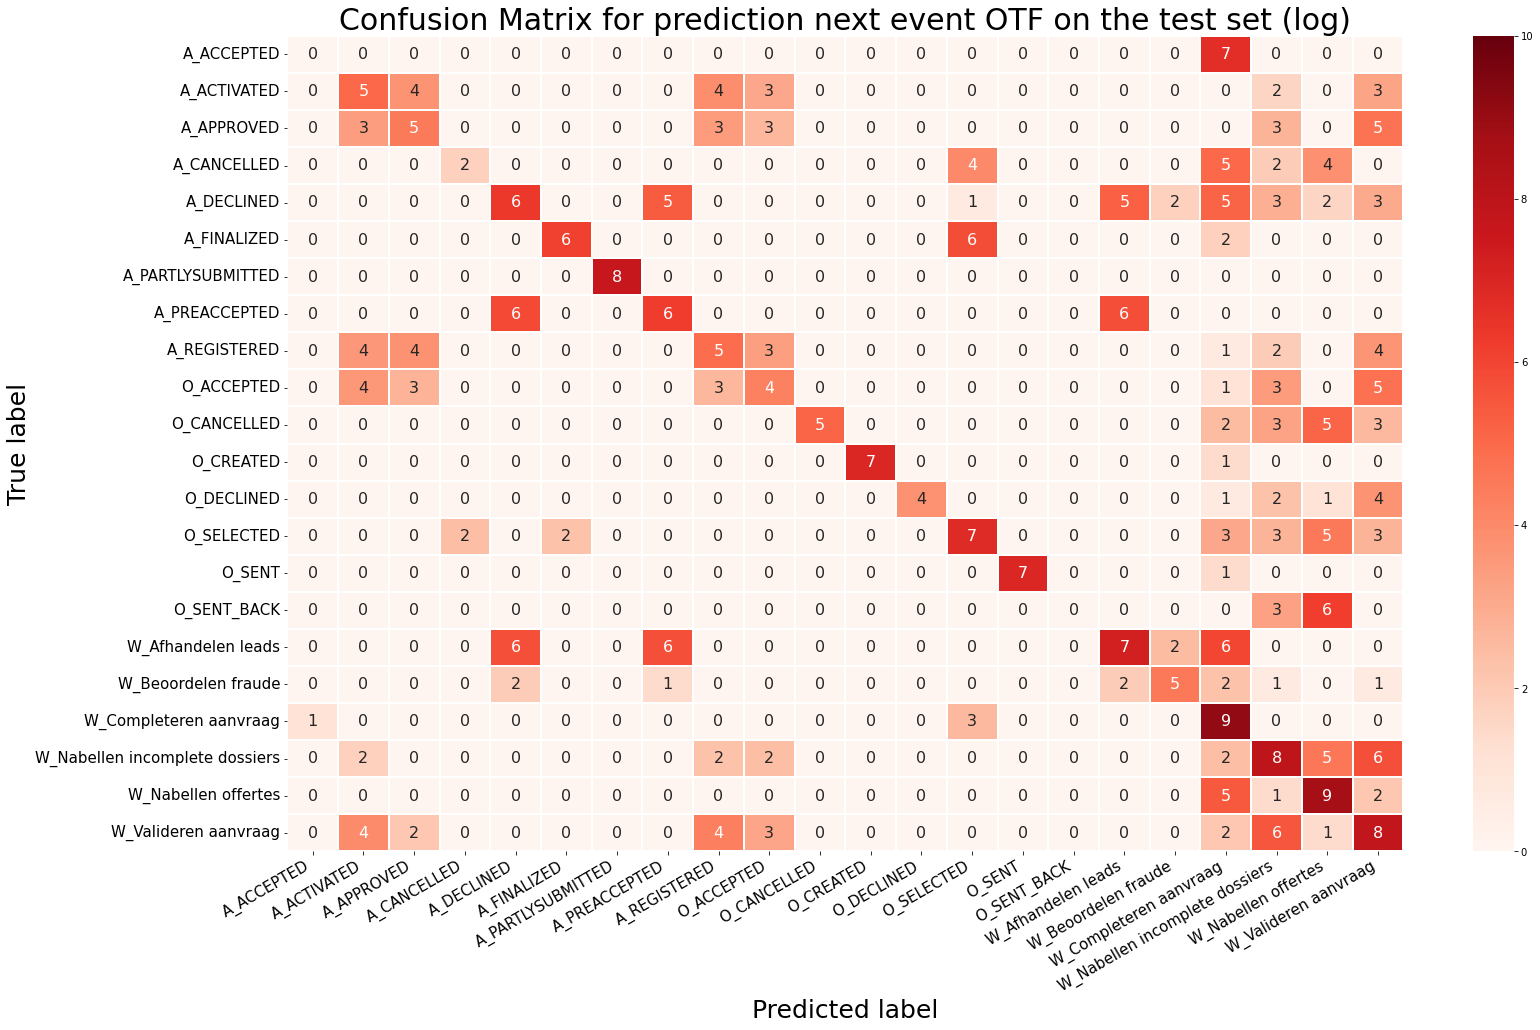

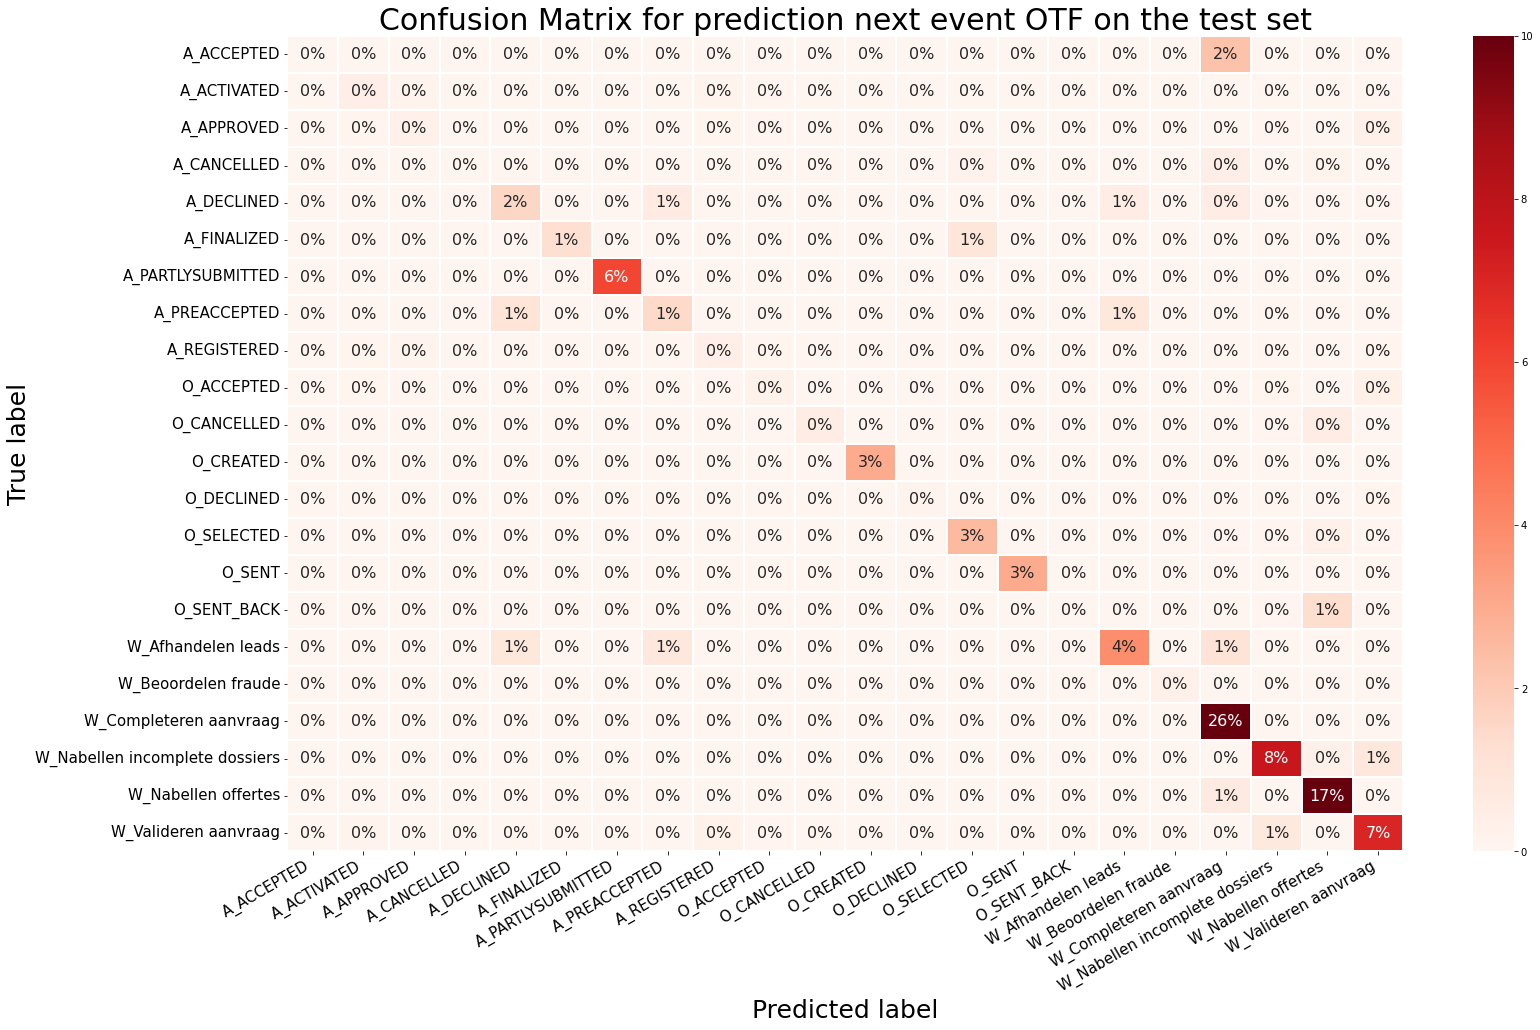

In [11]:
# Running the notebook that adds the on-the-fly event prediction to df and df_test
%run -i "event_onTheFly.ipynb"

In [12]:

df.head(10)

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,Position,OTF Prediction for Next Activity
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,1,W_Completeren aanvraag
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,2,W_Completeren aanvraag
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,3,W_Completeren aanvraag
3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,4,W_Completeren aanvraag
4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,5,A_ACCEPTED
5,10862,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,6,O_SELECTED
6,10862,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,8,W_Completeren aanvraag
7,10862,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,7,W_Completeren aanvraag
8,10862,COMPLETE,O_CREATED,2011-10-01 11:45:11.197000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,9,O_SENT
9,10862,COMPLETE,O_SENT,2011-10-01 11:45:11.380000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000,10,W_Nabellen offertes


In [15]:
df = df.sort_values(by=[case_column, timestamp_column]).reset_index(drop=True)
df_test = df_test.sort_values(by=[case_column, timestamp_column]).reset_index(drop=True)

training_event_otf_accuracy = len(df[(df[pred_event_otf].shift(periods=1)==df[event_column]) & (df[case_column].shift(periods=1) == df[case_column])]) * 100 / len(df[df[case_column].shift(periods=1) == df[case_column]])

test_event_otf_accuracy = len(df_test[(df_test[pred_event_otf].shift(periods=1)==df_test[event_column]) & (df_test[case_column].shift(periods=1) == df_test[case_column])]) * 100 / len(df_test[df_test[case_column].shift(periods=1) == df_test[case_column]])

training_event_otf_accuracy, test_event_otf_accuracy


(80.81242219747101, 81.60300633798867)

In [ ]:
# Accuracy % of the on-the-fly event predictions:

# training_event_accuracy = len(df[(df[baseline_next_event_column].shift(periods=1)==df[event_column]) & (df[case_column].shift(periods=1) == df[case_column])]) * 100 / len(df[df[case_column].shift(periods=1) == df[case_column]])

# test_event_accuracy = len(df_test[(df_test[baseline_next_event_column].shift(periods=1)==df_test[event_column]) & (df_test[case_column].shift(periods=1) == df_test[case_column])]) * 100 / len(df_test[df_test[case_column].shift(periods=1) == df_test[case_column]])

# training_event_accuracy, test_event_accuracy

In [ ]:
# Running the notebook that adds the on-the-fly event prediction to df and df_test
%run -i "timePrediction_onTheFly.ipynb" # Takes around 2 minutes to run

In [ ]:
df.head(10)

In [ ]:
# Mean Absolute Error of the on-the-fly time predictions:

# training_time_MAE = abs(df[timestamp_column] - df[baseline_next_timestamp_column].shift(periods=1))[df[case_column].shift(periods=1) == df[case_column]].mean()

# test_time_MAE = abs(df_test[timestamp_column] - df_test[baseline_next_timestamp_column].shift(periods=1))[df_test[case_column].shift(periods=1) == df_test[case_column]].mean()

# training_time_MAE, test_time_MAE